# Benchmark Results Analysis

This notebook loads all JSON files under `bench/results` and summarizes the benchmark runs.


In [1]:
from __future__ import annotations

from pathlib import Path
import json
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
results_dir = Path.cwd() / "results"
json_files = sorted(results_dir.glob("bench-runs-*.json"))
print(f"Found {len(json_files)} results files")

Found 6 results files


In [3]:
runs = []
rows = []

for path in json_files:
    payload = json.loads(path.read_text())
    file_id = path.stem
    for result in payload.get("results", []):
        runs.append({
            "file": file_id,
            "generatedAt": payload.get("generatedAt"),
            "run": result.get("run"),
            "success": result.get("success"),
            "exitCode": result.get("exitCode"),
            "durationMs": result.get("durationMs"),
            "status": result.get("status"),
        })
        for block in result.get("uiMetrics", []) or []:
            for row in block.get("rows", []) or []:
                trustworthiness = row.get("trustworthiness")
                quality_percent = trustworthiness * 100 if trustworthiness is not None else None
                wasm_features = row.get("wasmFeatures") or row.get("wasmMode", "")
                rows.append({
                    "file": file_id,
                    "scenario": row.get("scope", ""),
                    "Dataset": row.get("datasetName", ""),
                    "Run": row.get("runId"),
                    "Runtime (ms)": row.get("runtimeMs"),
                    "Memory (MB)": row.get("memoryDeltaMb"),
                    "Quality (%)": quality_percent,
                    "FPS": row.get("fpsAvg"),
                    "Latency (ms)": row.get("responsivenessMs"),
                    "WASM Features": wasm_features,
                    "datasetSize": row.get("datasetSize"),
                    "dimensions": row.get("dimensions"),
                })

runs_df = pd.DataFrame(runs)
rows_df = pd.DataFrame(rows)

print(f"Runs: {len(runs_df)}")
print(f"Rows: {len(rows_df)}")


Runs: 50
Rows: 60


In [4]:
# Run-level overview
runs_df.groupby("success").size().rename("count")


success
True    50
Name: count, dtype: int64

In [5]:
# Duration by file
runs_df.groupby("file")["durationMs"].agg(["count", "mean", "min", "max"]).sort_values("mean", ascending=False)


,count,mean,min,max
file,,,,
bench-runs-1769325915738,10,298728.6,278914,422927
bench-runs-1769329740204,10,93131.1,90692,97343
bench-runs-1769328903778,10,83576.9,81542,90427
bench-runs-1769325211974,10,70309.9,67838,75106
bench-runs-1769324540016,10,67114.1,62523,71102


In [6]:
# Scenario-level summary
summary = (
    rows_df.groupby(["scenario", "WASM Features", "Dataset"], dropna=False)
    .agg(
        runs=("Run", "count"),
        runtime_ms_mean=("Runtime (ms)", "mean"),
        runtime_ms_p95=("Runtime (ms)", lambda s: s.quantile(0.95)),
        memory_mb_mean=("Memory (MB)", "mean"),
        quality_mean=("Quality (%)", "mean"),
        fps_mean=("FPS", "mean"),
        latency_ms_mean=("Latency (ms)", "mean"),
    )
    .reset_index()
    .sort_values("runtime_ms_mean", ascending=False)
)
summary.head(20)


,scenario,WASM Features,Dataset,runs,runtime_ms_mean,runtime_ms_p95,memory_mb_mean,quality_mean,fps_mean,latency_ms_mean
0,mid,"Dist,Tree,Matrix,NN,Opt",Medium Clustered (1K points),10,6611.93,6880.485,0.0,94.285250,60.112096,78.376000
1,mid,none,Medium Clustered (1K points),10,6387.16,7514.350,0.0,94.339494,43.419213,46.675333
2,mid,none,"Swiss Roll (1K points, 3D manifold)",10,3930.57,4059.105,0.0,99.667347,59.980317,24.332000
5,small,none,Small Random (100 points),10,3586.34,3741.615,0.0,86.503783,45.250642,28.386000
3,small,"Dist,Tree,Matrix,NN,Opt",Small Random (100 points),10,2480.71,2517.415,0.0,85.372495,60.005876,12.118000
4,small,none,"Iris Dataset (150 points, 4D)",10,2451.86,2544.735,0.0,98.715970,59.998754,10.962667


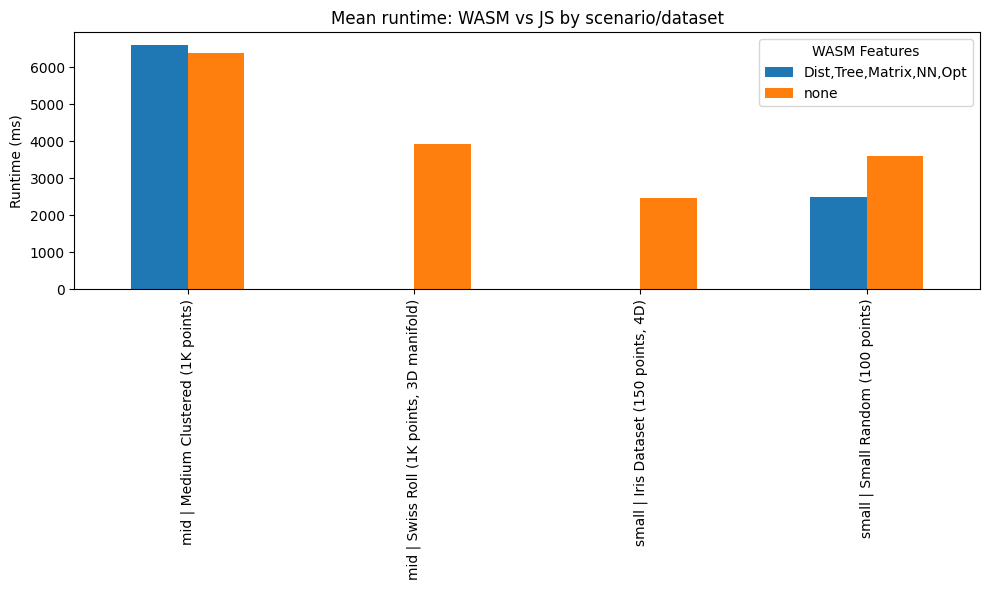

In [7]:
compare = (
    rows_df.groupby(["scenario", "Dataset", "WASM Features"], dropna=False)
    .agg(runtime_ms_mean=("Runtime (ms)", "mean"))
    .reset_index()
)

pivot = compare.pivot_table(
    index=["scenario", "Dataset"],
    columns="WASM Features",
    values="runtime_ms_mean",
)

plot_df = pivot.reset_index()
plot_df["label"] = plot_df["scenario"].astype(str) + " | " + plot_df["Dataset"].astype(str)
plot_df = plot_df.set_index("label").drop(columns=["scenario", "Dataset"])

ax = plot_df.plot(kind="bar", figsize=(10, 6))
ax.set_title("Mean runtime: WASM vs JS by scenario/dataset")
ax.set_ylabel("Runtime (ms)")
ax.set_xlabel("")
ax.legend(title="WASM Features")
plt.tight_layout()
